In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization tools


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'sample_submission.csv', 'embeddings']


# Exploratory Data Analysis

Number of sincere questions: 1225312
Number of sincere questions: 80810


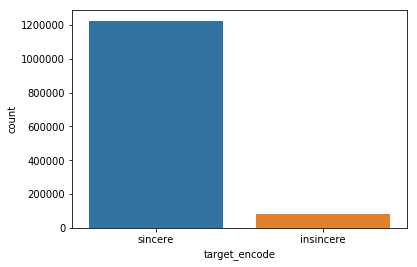

In [41]:
#Loading in dataset
data = pd.read_csv('../input/train.csv')

# Distribution of labels
data['target_encode'] = data['target'].replace([0,1],['sincere','insincere'])
target_plot = sns.countplot(x='target_encode', data=data)
target_plot
print('Number of sincere questions:',len(data[data['target_encode']=='sincere']))
print('Number of sincere questions:',len(data[data['target_encode']=='insincere']))

As expected beforehand, the the general distribtuion of the dataset is highly skewed, meaning the amount of insincere comments is much less than the amount of sincere comments in the training dataset. It will definitely later affect the choice of evaluation metrics for the models. 

# Text Pre-processing / Feature Engineering

In [42]:
import string
from nltk.corpus import stopwords

#Tokenization function
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

# Vectorization & TF-IDF Transformation tools
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Preidcition Model & Data Pipeline 
For the prediction models, Naives Bayes Classifier turns out to be a simple, yet pretty powerful model for many text classification problem for various reasons. We will incorporate the model into our data pipeline with all other preivous preprocessing techniques

In [43]:
# Naives Bayes model
from sklearn.naive_bayes import MultinomialNB

# Create a data pipeline for training and testing our models
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

# Train-Test Split our the public dataset

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = \
train_test_split(data['question_text'], data['target'], test_size=0.2)

print("Number of Training Instances:",len(X_train))
print("Number of Testing Instances:",len(X_test))

Number of Training Instances: 1044897
Number of Testing Instances: 261225


In [45]:
training_data = pd.DataFrame({'questions_text':X_train,'target':Y_train})

# Under/Down Sampling the imblance dataset

The resampling technique should be just applied to the training dataset. There are two advantages of downsampling our dataset:
* **Training time is faster**
* **The classification algorithm (in this case Naives Bayes) might not be overwhelmed with the number of instances from one particular class. **

In [46]:
# Downsampling the dataset so the ratio of sincere:insincere apprximmately 1:1
data_sincere = training_data[training_data['target']==0]
data_insincere = training_data[training_data['target']==1]
data_sincere_downsample = data_sincere.sample(n=98000)

data_downsample = pd.concat([data_insincere, data_sincere_downsample], axis=0)

print(data_downsample.target.value_counts())


0    98000
1    64457
Name: target, dtype: int64


# Train, Test, and Evaluate the Model
Since our training example is pretty balance now, it should be expected that the precision socre for each class should be high (as long as the we have the right parameter and algorithm). However, all other metrics should also be taken into consideration.

In [47]:
# Train the model
pipeline.fit(data_downsample['questions_text'],data_downsample['target'])

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x7ffaddb68620>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=No...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [48]:
# Predict on the testing set and evaluate the model
predictions = pipeline.predict(X_test)

# Classication report
from sklearn.metrics import classification_report
print(classification_report(predictions,Y_test))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93    216663
           1       0.83      0.31      0.45     44562

   micro avg       0.87      0.87      0.87    261225
   macro avg       0.85      0.65      0.69    261225
weighted avg       0.87      0.87      0.84    261225



# Predict and Submit the Test file

In [49]:
# Read in test data and check the dataframes
test_data = pd.read_csv('../input/test.csv')

# Make a prediction and output to csv file
test_data_predictions = pipeline.predict(test_data['question_text'])

test_data['prediction'] = test_data_predictions
test_data.to_csv('submission.csv', columns=['qid','prediction'], index=False)